# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [6]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [7]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [8]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [9]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [10]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [11]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [12]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [14]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [15]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [16]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [17]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [18]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [19]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [20]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

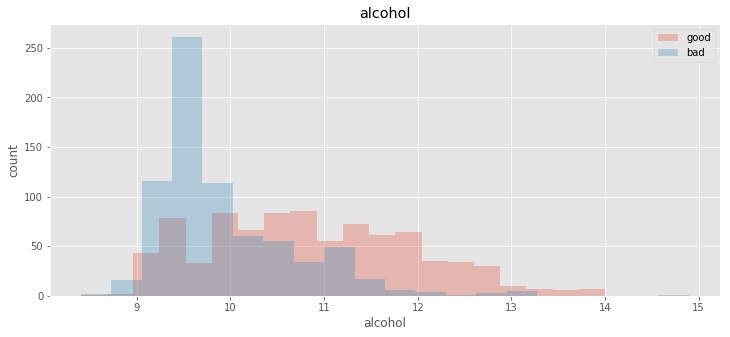

In [21]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [22]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [24]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [25]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [26]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [27]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [28]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [29]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [426]:
from sklearn.base import ClusterMixin, BaseEstimator
import operator
import scipy.spatial.distance as ssd

def distance(x,y,metric):
    return ssd.pdist((x,y),metric)[0]

def start_centroids(self,X):
    if self.init=='random':
        indexes=np.random.choice(X.shape[0]-1,self.k)
        k=0
        for i in indexes:
            self.centroids[k]=X[i]
            k=k+1
    if self.init=='++': #k-means ++, просто по другому задаем центроиды
        self.centroids[0]=X[np.random.choice(X.shape[0]-1)]
        for i in xrange(1,self.k):
            D=np.array([min([distance(x,c,self.metric)**2 for c in self.centroids])for x in X])
            prob=D/D.sum()
            self.centroids[i]=X[np.random.choice(np.arange(X.shape[0])-1, p=prob)] # append почему то ругается
    return self.centroids
 

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init=init

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k,X.shape[1]))
        
        ## Your Code Here
        # ...
        eps=0.001
        summ=1.0
        iterator=0
        dist=np.zeros(self.k)
        self.centroids=start_centroids(self,X)
        while summ>eps and iterator<self.max_iter:
            summ=0.0
            for i in xrange(X.shape[0]):
                for j in xrange(self.k):
                    dist[j]=distance(X[i],self.centroids[j],self.metric)
                index, value = min(enumerate(dist), key=operator.itemgetter(1))
                self.labels[i]=index
            for i in xrange(self.k):
                M=list()
                for j in xrange(X.shape[0]):
                    if self.labels[j]==i:
                        M.append(X[j])
                M=np.array(M)
                if len(M)!=0:
                    M.mean(axis=0)
                    summ=summ+distance(self.centroids[i],M.mean(axis=0),self.metric)
                    self.centroids[i]=M.mean(axis=0) 
                else:
                    summ=summ 
                    self.centroids[i]=self.centroids[i]
            iterator=iterator+1
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """

class MiniBatchKMeans(Kmeans):
    def __init__(self, k=8, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size=10):
        Kmeans.__init__ (self, k, metric, max_iter, random_state, init)
        self.batch_size=batch_size
    def fit(self,X,y=None):    
        np.random.seed(self.random_state)
        self.centroids = np.empty((self.k,X.shape[1]))
        self.centroids=start_centroids(self,X)
        v=np.zeros(self.k)
        self.labels = np.empty(X.shape[0])
        summ=1
        eps=0.001*self.batch_size/X.shape[0]
        iterator=0
        while summ>eps and iterator<self.max_iter:
            iterator=iterator+1
            summ=0.0
            M_indexes=np.random.choice((X.shape[0]-1),self.batch_size)
            M=np.array([X[i] for i in M_indexes])
            d=list()
            dist=np.zeros(self.k)
            for j in xrange(self.batch_size):
                for k in xrange(self.k):
                    dist[k]=distance(M[j],self.centroids[k],self.metric)
                index, value = min(enumerate(dist), key=operator.itemgetter(1))
                d.append(index)
                self.labels[(M_indexes[j])]=index;
            for j in xrange(self.batch_size):
                a=d[j]
                v[a]=v[a]+1
                eta=1/v[a]
                summ=summ+distance(self.centroids[a],(1-eta)*self.centroids[a],self.metric)
                self.centroids[a]=(1-eta)*self.centroids[a]+eta*M[j]
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [360]:
from sklearn.datasets import make_blobs

In [361]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

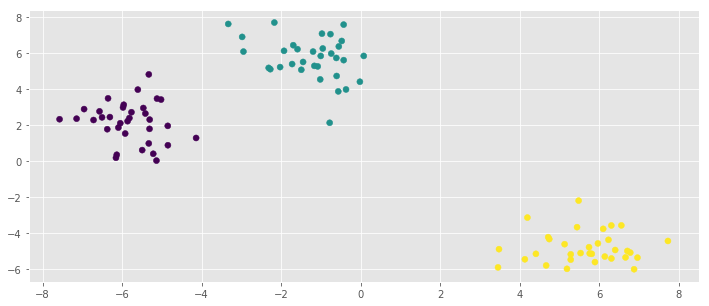

In [362]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

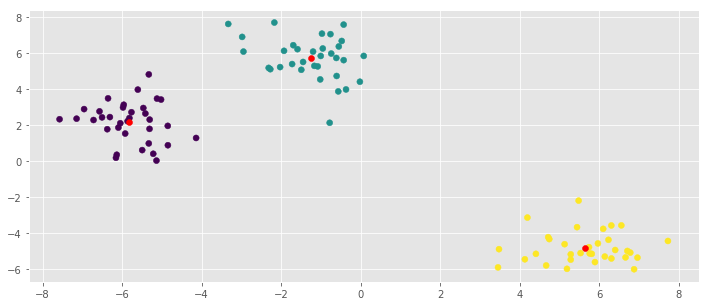

In [363]:
## Работоспособность KMeans
modelK = Kmeans(3, 'euclidean', 1000, None, 'random')
modelK.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelK.centroids[:,0],modelK.centroids[:,1],c='red') 

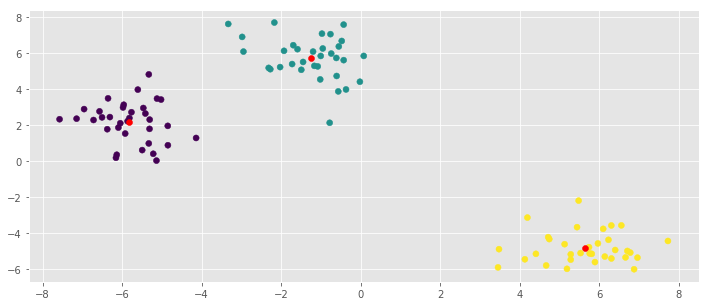

In [364]:
## Работоспособность KMeans++
modelKpp = Kmeans(3, 'euclidean', 1000, None, '++')
modelKpp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelKpp.centroids[:,0],modelKpp.centroids[:,1],c='red')

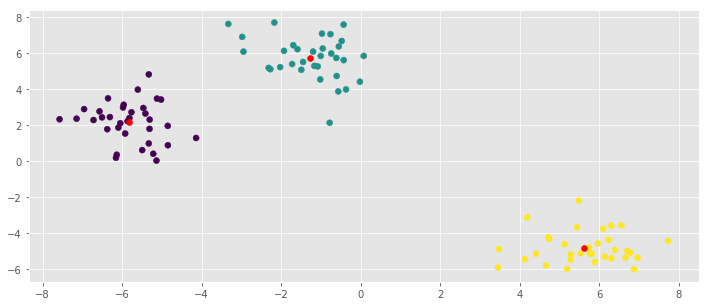

In [365]:
## Работоспособность KMeans с MiniBatchKMeans
modelMB = MiniBatchKMeans(3, 'euclidean', 1000, None, 'random')
modelMB.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelMB.centroids[:,0],modelMB.centroids[:,1],c='red')

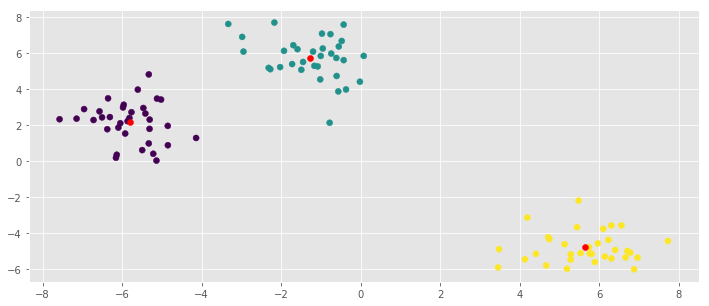

In [366]:
## Работоспособность KMeans++ с MiniBatchKMeans
modelMBpp = MiniBatchKMeans(3, 'euclidean', 1000, None, '++')
modelMBpp.fit(X, y)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.scatter(modelMBpp.centroids[:,0],modelMBpp.centroids[:,1],c='red')

In [382]:
## Время выполнения алгоритма KMeans
model=Kmeans(k=3,init='random')
measure_k = list()
for i in xrange(100,1000,100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_k.append(res.best)
    print "size={0}, time = {1}".format(i, measure_k[i/100-1])

size=100, time = 0.0591289997101
size=200, time = 0.0679049491882
size=300, time = 0.150786161423
size=400, time = 0.133720159531
size=500, time = 0.251842021942
size=600, time = 0.19961810112
size=700, time = 0.359313964844
size=800, time = 0.680808067322
size=900, time = 0.615751981735


In [383]:
## Время выполнения алгоритма KMeans++
model=Kmeans(k=3,init='++')
model=Kmeans(k=3,init='random')
measure_kpp = list()
for i in xrange(100,1000,100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_kpp.append(res.best)
    print "size={0}, time = {1}".format(i, measure_kpp[i/100-1])

size=100, time = 0.0356659889221
size=200, time = 0.0700278282166
size=300, time = 0.104075908661
size=400, time = 0.133825063705
size=500, time = 0.17370891571
size=600, time = 0.30456495285
size=700, time = 0.469038963318
size=800, time = 0.533133983612
size=900, time = 0.299300909042


In [384]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
model=MiniBatchKMeans(k=3,init='random')
model=Kmeans(k=3,init='random')
measure_mb = list()
for i in xrange(100,1000,100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_mb.append(res.best)
    print "size={0}, time = {1}".format(i, measure_mb[i/100-1])

size=100, time = 0.0390558242798
size=200, time = 0.0711920261383
size=300, time = 0.100703001022
size=400, time = 0.207099914551
size=500, time = 0.171895980835
size=600, time = 0.399118185043
size=700, time = 0.233618021011
size=800, time = 0.404226064682
size=900, time = 0.597483873367


In [385]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
model=MiniBatchKMeans(k=3,init='++')
model=Kmeans(k=3,init='random')
measure_mbpp = list()
for i in xrange(100,1000,100):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
                        center_box=(-10, 10), shuffle=False, random_state=1234) 
    res = %timeit -o -q -n 1 -r 5 model.fit(X)
    measure_mbpp.append(res.best)
    print "size={0}, time = {1}".format(i, measure_mbpp[i/100-1])

size=100, time = 0.0525159835815
size=200, time = 0.0676839351654
size=300, time = 0.100739002228
size=400, time = 0.20035982132
size=500, time = 0.166622877121
size=600, time = 0.199814081192
size=700, time = 0.348273038864
size=800, time = 0.533024072647
size=900, time = 0.4478931427


In [386]:
size=range(100,1000,100)

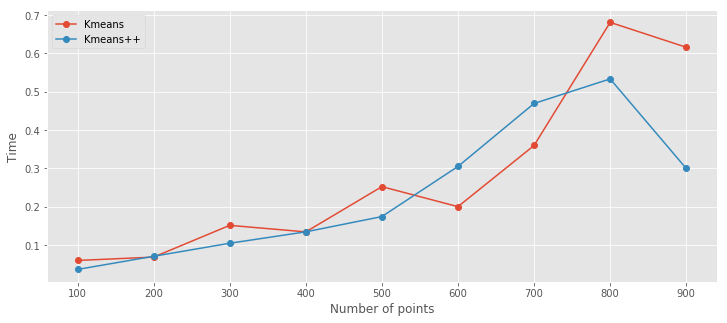

In [387]:
plt.plot(size, measure_k, marker = 'o', label = 'Kmeans')
plt.plot(size, measure_kpp, marker = 'o', label = 'Kmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

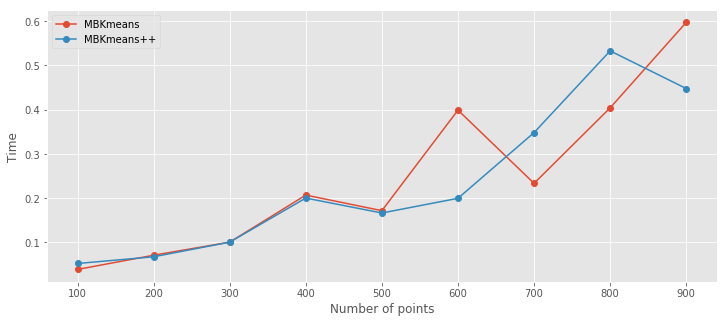

In [388]:
plt.plot(size, measure_mb, marker = 'o', label = 'MBKmeans')
plt.plot(size, measure_mbpp, marker = 'o', label = 'MBKmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

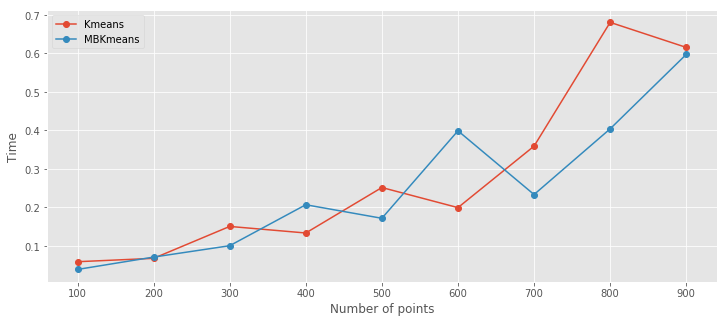

In [389]:
plt.plot(size, measure_k, marker = 'o', label = 'Kmeans')
plt.plot(size, measure_mb, marker = 'o', label = 'MBKmeans')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

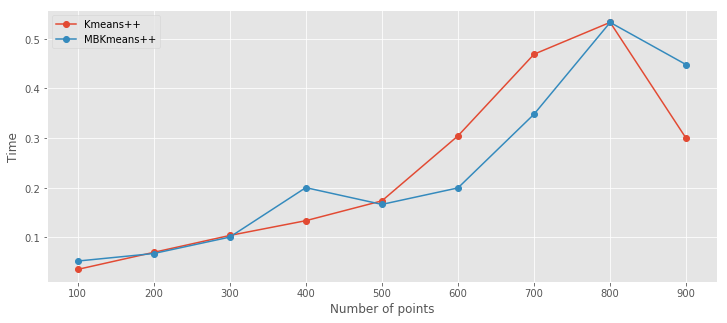

In [390]:
plt.plot(size, measure_kpp, marker = 'o', label = 'Kmeans++')
plt.plot(size, measure_mbpp, marker = 'o', label = 'MBKmeans++')
plt.legend()
plt.axes().set_xlabel("Number of points")
plt.axes().set_ylabel("Time")

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [285]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [286]:
df=df_sns.drop(['gradyear','gender','age','friends'],axis=1)

In [287]:
df.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [288]:
df=df.values
df=(df-df.mean(axis=0))/df.std(axis=0)

In [412]:
## KMeans
model_k = Kmeans(9, init='random')
model_k.fit(df,y=None)

Kmeans(init='random', k=9, max_iter=1000, metric='euclidean',
    random_state=None)

In [424]:
df_sns.loc [:, 'Kmeans'] = model_k.labels
df_sns.groupby('Kmeans') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans++, mean)","(MBKmeans, mean)","(MBKmeans++, mean)"
Kmeans,,,,,,,,,,,,,,,,,,,,,
0.0,1376,2007.258653,17.968448,35.063562,0.236627,0.228446,0.229075,0.142228,0.132788,0.122089,...,0.180617,0.039018,0.025173,0.200126,0.135305,0.020138,0.041536,3.225299,5.611705,2.822530
1.0,323,2007.363402,19.037362,35.886598,0.358247,0.270619,0.244845,0.164948,0.118557,0.180412,...,0.167526,0.038660,0.020619,0.378866,0.278351,0.090206,0.110825,2.033505,7.533505,2.951031
2.0,14981,2007.444281,18.200786,26.962872,0.117634,0.120950,0.148674,0.064742,0.061589,0.066264,...,0.048271,0.014460,0.009132,0.120080,0.075288,0.000000,0.020820,5.012775,3.789411,1.207491
3.0,634,2007.640054,17.545478,30.587280,0.658999,0.571042,0.380244,0.305819,0.234100,0.308525,...,0.837618,0.169147,0.162382,1.338295,0.572395,0.602165,1.040595,5.894452,1.534506,3.589986
4.0,1150,2007.350640,18.033597,31.507148,0.172310,0.206922,0.198646,0.111362,0.097065,0.113619,...,0.156509,0.033108,0.022573,0.300978,0.170805,1.417607,0.170805,4.884123,2.911211,2.651618
5.0,3383,2007.716012,17.521685,36.878902,0.239930,0.271903,0.318731,0.108510,0.121098,0.380916,...,0.413394,0.057905,0.033484,0.224572,0.158359,0.022659,0.043555,4.553374,4.883182,3.551108
6.0,1860,2007.723726,17.370401,34.788435,1.491969,1.190913,0.613584,1.069757,0.852226,0.162919,...,0.146397,0.034419,0.022028,0.130335,0.108307,0.026618,0.030748,3.174851,0.726480,4.581459
7.0,712,2007.856973,17.487098,40.984505,0.371871,0.399285,0.314660,0.179976,0.251490,0.257449,...,0.415971,1.516091,1.169249,0.212157,0.156138,0.084625,0.075089,1.095352,5.738975,7.380215
8.0,495,2007.344464,17.906135,32.662566,0.191564,0.297012,0.135325,0.119508,0.093146,0.151142,...,0.137083,0.012302,0.012302,0.186292,0.128295,0.042179,0.038664,7.970123,4.822496,3.181019


In [414]:
## KMeans++
model_kpp = Kmeans(9, init='++')
model_kpp.fit(df,y=None)

Kmeans(init='++', k=9, max_iter=1000, metric='euclidean', random_state=None)

In [415]:
df_sns.loc [:, 'Kmeans++'] = model_kpp.labels
df_sns.groupby('Kmeans++') ['age'].aggregate (['count']).join (df_sns.groupby('Kmeans++').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(shopping, mean)","(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(MBKmeans, mean)"
Kmeans++,,,,,,,,,,,,,,,,,,,,,
0.0,468,2007.194757,17.928936,34.998127,0.355805,0.372659,0.249064,0.179775,0.177903,0.159176,...,0.818352,0.290262,0.074906,0.044944,0.220974,0.138577,0.095506,0.056180,0.185393,2.161049
1.0,708,2007.853541,17.501493,40.908764,0.358944,0.403361,0.309724,0.166867,0.253301,0.258103,...,0.918367,0.409364,1.513806,1.174070,0.216086,0.152461,0.110444,0.074430,6.939976,4.075630
2.0,359,2007.350797,19.142448,35.120729,0.337130,0.275626,0.241458,0.157175,0.120729,0.177677,...,0.364465,0.164009,0.038724,0.020501,0.341686,0.287016,0.138952,0.084282,1.264237,5.917995
3.0,1797,2007.726014,17.389902,35.398091,1.491647,1.142243,0.499284,1.157041,0.893556,0.165155,...,0.345585,0.146539,0.032936,0.023866,0.141766,0.103580,0.060143,0.030072,5.851551,4.536993
4.0,3817,2007.646347,17.642340,36.046168,0.227925,0.264680,0.411923,0.102196,0.115643,0.374272,...,1.077095,0.409682,0.058494,0.033393,0.225459,0.191618,0.098835,0.040117,4.144330,2.069476
5.0,15406,2007.422486,18.197199,27.096005,0.121702,0.127583,0.138656,0.060718,0.060877,0.059447,...,0.135265,0.042068,0.013882,0.008636,0.120748,0.072799,0.050758,0.021511,2.043976,3.047950
6.0,749,2007.593533,17.642327,30.139723,0.571594,0.497691,0.354503,0.267898,0.204388,0.269053,...,0.540416,0.703233,0.132794,0.138568,1.316397,0.515012,0.855658,1.114319,3.157044,0.210162
7.0,959,2007.758681,17.463391,34.860243,0.282118,0.256076,0.230903,0.158854,0.138021,0.151042,...,0.399306,0.218750,0.053819,0.029514,0.197917,0.100694,0.111979,0.039931,4.010417,2.012153
8.0,651,2007.354362,18.048103,32.930201,0.166443,0.275168,0.150336,0.122148,0.083221,0.146309,...,0.291275,0.130201,0.012081,0.010738,0.167785,0.123490,0.053691,0.033557,6.649664,1.783893


In [441]:
## KMeans с MiniBatchKMeans
model_mb = MiniBatchKMeans(9, init='random',batch_size=1000)
model_mb.fit(df,y=None)

MiniBatchKMeans(batch_size=1000, init='random', k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [442]:
df_sns.loc [:, 'MBKmeans'] = model_mb.labels
df_sns.groupby('MBKmeans') ['age'].aggregate (['count']).join (df_sns.groupby('MBKmeans').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(Kmeans++, mean)","(MBKmeans++, mean)"
MBKmeans,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,1142,2007.705706,17.459846,32.037538,1.588589,1.494745,0.647898,0.602853,0.382132,0.143393,...,0.161411,0.026276,0.015766,0.142643,0.097598,0.064565,0.036036,5.695946,3.177177,4.390390e+00
6.906620e-310,1,2009.000000,18.724000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,1.482098e-319
1.000000e+00,1213,2007.764706,17.738309,36.974486,0.353650,0.309709,0.250177,0.155918,0.119064,0.120482,...,0.363572,0.075124,0.041106,0.187101,0.150957,0.096386,0.034018,4.120482,4.309001,3.198441e+00
2.000000e+00,1776,2007.600952,17.847208,35.198095,0.215714,0.235238,0.197143,0.136190,0.114286,0.124762,...,0.227619,0.038095,0.021429,0.260476,0.156667,0.111905,0.041429,3.921905,5.012857,2.868095e+00
3.000000e+00,3068,2007.659657,17.501274,36.770338,0.340343,0.279745,0.526287,0.438572,0.513282,0.521583,...,0.272828,0.051467,0.027117,0.148866,0.117875,0.058384,0.028224,4.029054,4.138351,3.241284e+00
4.000000e+00,14191,2007.423772,18.241631,26.386446,0.134109,0.129694,0.123903,0.063987,0.049481,0.043977,...,0.045926,0.012499,0.008600,0.119145,0.075626,0.047876,0.020240,2.143684,4.985150,1.226822e+00
5.000000e+00,715,2007.861374,17.484243,41.251185,0.399289,0.394550,0.312796,0.210900,0.267773,0.257109,...,0.418246,1.513033,1.178910,0.215640,0.161137,0.103081,0.072275,6.902844,1.140995,7.338863e+00
6.000000e+00,844,2007.576410,17.638214,30.274872,0.500513,0.480000,0.312821,0.272821,0.183590,0.266667,...,0.705641,0.126154,0.124103,1.305641,0.547692,0.873846,1.045128,3.240000,5.747692,3.962051e+00
7.000000e+00,580,2007.373887,18.060719,32.991098,0.198813,0.295252,0.133531,0.160237,0.089021,0.151335,...,0.145401,0.010386,0.011869,0.206231,0.167656,0.057864,0.041543,7.035608,7.391691,3.146884e+00


Выбирали точки случайно, одну в итоге не выбрали.

In [443]:
## KMeans++ с MiniBatchKMeans
model_mbpp = MiniBatchKMeans(9, init='++',batch_size=1000)
model_mbpp.fit(df,y=None)

MiniBatchKMeans(batch_size=1000, init='++', k=9, max_iter=1000,
        metric='euclidean', random_state=None)

In [444]:
df_sns.loc [:, 'MBKmeans++'] = model_mbpp.labels
df_sns.groupby('MBKmeans++') ['age'].aggregate (['count']).join (df_sns.groupby('MBKmeans++').aggregate
(['mean']))

,count,"(gradyear, mean)","(age, mean)","(friends, mean)","(basketball, mean)","(football, mean)","(soccer, mean)","(softball, mean)","(volleyball, mean)","(swimming, mean)",...,"(clothes, mean)","(hollister, mean)","(abercrombie, mean)","(die, mean)","(death, mean)","(drunk, mean)","(drugs, mean)","(Kmeans, mean)","(Kmeans++, mean)","(MBKmeans, mean)"
MBKmeans++,,,,,,,,,,,,,,,,,,,,,
0.000000e+00,3092,2007.592109,17.627025,36.013059,0.253404,0.255627,0.270631,0.116421,0.117533,0.292859,...,0.564046,0.061128,0.035288,0.190886,0.160600,0.033343,0.034732,3.636010,3.619061,3.498472e+00
1.482098e-319,1,2009.000000,18.724000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,6.906620e-310
1.000000e+00,964,2007.451872,17.930098,33.551693,0.222816,0.267380,0.235294,0.125668,0.100713,0.130125,...,0.165775,0.033868,0.018717,0.925134,0.417112,1.261141,0.101604,3.738859,4.827094,3.989305e+00
2.000000e+00,481,2007.789292,17.255150,36.514680,0.397237,0.374784,0.374784,0.219344,0.243523,0.217617,...,0.316062,0.093264,0.075993,0.233161,0.120898,0.084629,0.051813,4.409326,6.340242,2.858377e+00
3.000000e+00,1901,2007.738385,17.351788,35.504736,1.465043,1.227785,0.607127,1.041498,0.846189,0.178169,...,0.131258,0.038340,0.019396,0.138024,0.108254,0.031574,0.027966,5.722598,3.138024,1.568336e+00
4.000000e+00,16272,2007.437883,18.185982,27.633072,0.120870,0.121121,0.158381,0.067490,0.063172,0.085568,...,0.038315,0.015667,0.009441,0.110977,0.073667,0.020237,0.019735,2.100733,4.937632,3.896103e+00
5.000000e+00,206,2007.405738,18.906267,32.127049,0.409836,0.352459,0.426230,0.114754,0.172131,0.221311,...,0.192623,0.069672,0.086066,0.188525,0.118852,0.045082,0.053279,3.401639,4.176230,3.401639e+00
6.000000e+00,594,2007.625544,17.580340,28.560232,0.595065,0.512337,0.325109,0.288824,0.235123,0.304790,...,0.741655,0.152395,0.155298,1.139332,0.483309,0.666183,1.438316,3.065312,5.841800,5.853411e+00
7.000000e+00,703,2007.855596,17.505922,41.187726,0.376655,0.405535,0.323706,0.194946,0.250301,0.256318,...,0.407942,1.511432,1.174489,0.211793,0.161252,0.093863,0.072202,6.850782,1.057762,4.945848e+00


Посмотрим на степень схожести кластеров

In [450]:
import sklearn.metrics
print sklearn.metrics.cluster.adjusted_rand_score(model_k.labels, model_kpp.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_mb.labels, model_mbpp.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_k.labels, model_mb.labels)
print sklearn.metrics.cluster.adjusted_rand_score(model_kpp.labels, model_mbpp.labels)

0.73596674146
0.582506014558
0.679332006547
0.749780564841


Проинтерпретируем кластеры. Для этого возьмем результаты k-means.

Cluster 0
Students = 468, Age = 17.9289358974, friends=34.9981273408


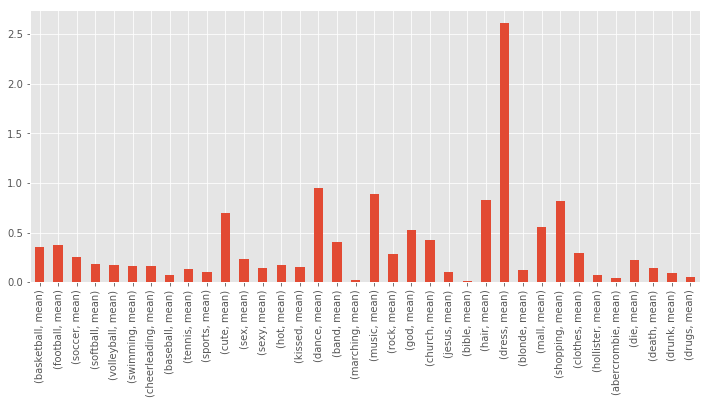

Cluster 1
Students = 708, Age = 17.5014929379, friends=40.9087635054


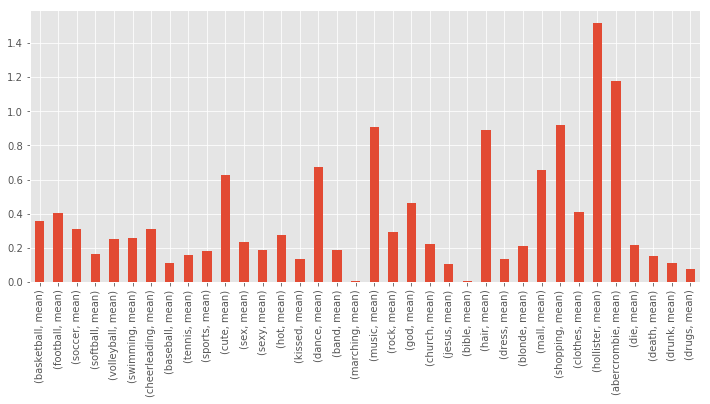

Cluster 2
Students = 359, Age = 19.142448468, friends=35.1207289294


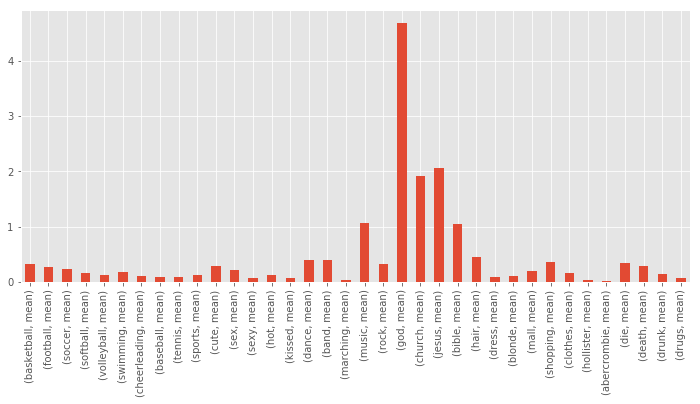

Cluster 3
Students = 1797, Age = 17.389902059, friends=35.3980906921


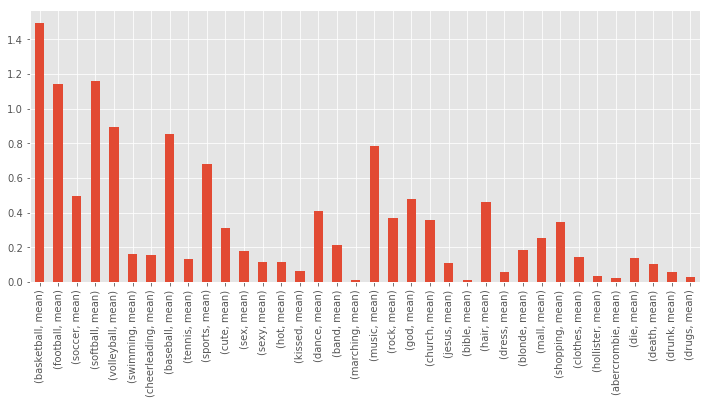

Cluster 4
Students = 3817, Age = 17.6423400576, friends=36.0461676378


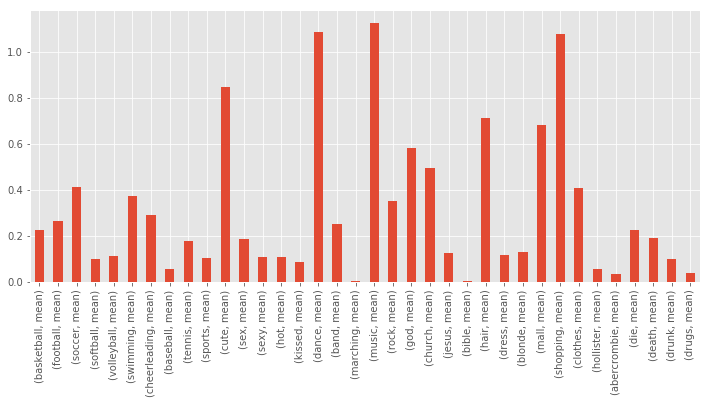

Cluster 5
Students = 15406, Age = 18.1971988186, friends=27.0960050864


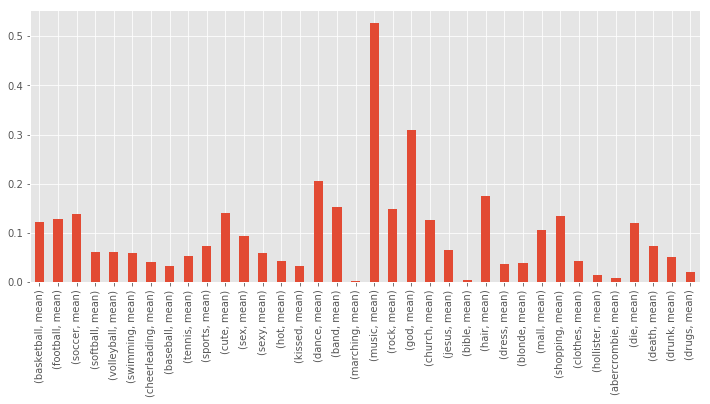

Cluster 6
Students = 749, Age = 17.6423271028, friends=30.1397228637


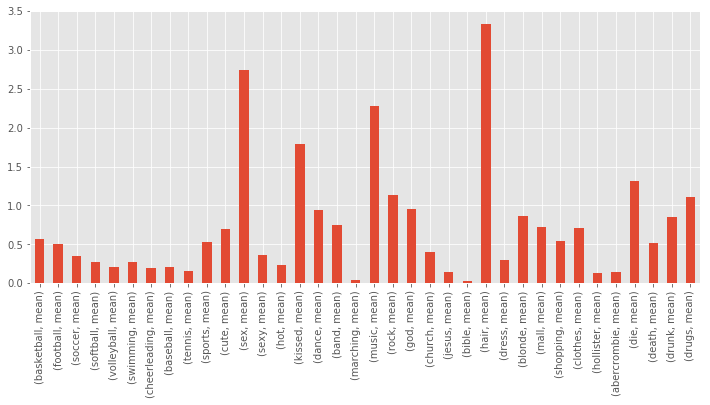

Cluster 7
Students = 959, Age = 17.4633910323, friends=34.8602430556


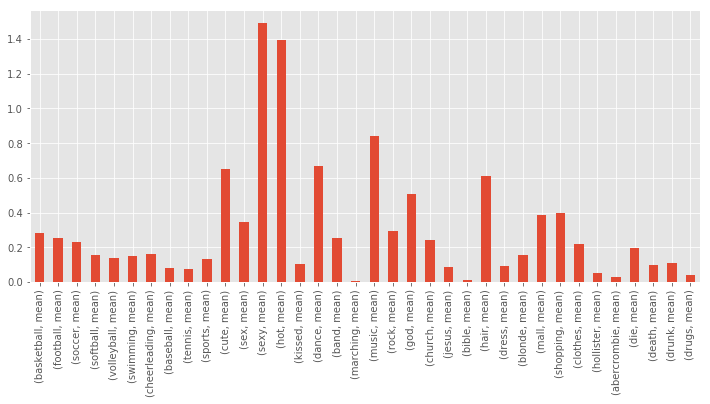

Cluster 8
Students = 651, Age = 18.0481029186, friends=32.9302013423


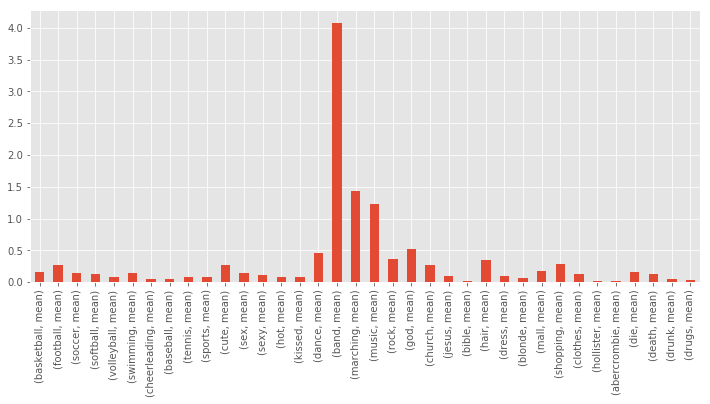

In [440]:
df_sns.loc [:, 'Kmeans'] = model_k.labels
interpretation = df_sns.groupby('Kmeans++') ['age'].aggregate (['count']).join(df_sns.groupby('Kmeans++').
                                                                               aggregate (['mean']))
for i in xrange(0, 9):
    print "Cluster {}".format(i)
    print "Students = {0}, Age = {1}, friends={2}".format (interpretation.iloc[i,0],
                                                                              interpretation.iloc[i,2],
                                                                              interpretation.iloc[i,3])
    interpretation.iloc[i, 4:40].plot.bar()
    plt.show()

## Вывод
Алгоритмы с "++" инициализацией в среднем работают быстрее за счет удачного выбора начальных точек. Быстрее всего работает MiniBatchKMeans++, но его точность хуже, чем у KMeans. У MiniBatchKMeans есть довольно существеный недостаток: из-за того, что точки выбираются в нем случайно, может потребоваться много итераций, чтобы для всех точек найти ближайщий кластер. Недостатком всех алгоритмов является случайная инициализация. На примере (график с явными тремя кластерами) в некоторых случаях не везет, и 2 точки попадают изначально в один кластер, в результате получается совершенно не тот результат, который хотелось бы увидеть. 

В итоге: если важна точность, то KMeans++, если скорость - MiniBatchKMeans++.